# Queries for OverpassAPI with overpy, shapely and requests

## geolocation by name, get IDnumber

NOTE: Search by area using relation or way id. First lookup OSM id in osm.org. The area id needs to be OSM id + 2400000000 for ways and OSM id + 3600000000 for relations. See https://wiki.osm.org/wiki/Overpass_API/Overpass_QL#By_area_.28area.29


In [58]:
from geopy.geocoders import Nominatim
import overpy

city_name = "córdoba"

# Geocoding request via Nominatim
geolocator = Nominatim(user_agent="city_compare")
geo_results = geolocator.geocode(city_name, exactly_one=False, limit=3)

# Searching for relation in result set
for r in geo_results:
    print(r.address, r.raw.get("osm_type"))
    if r.raw.get("osm_type") == "relation":
        city = r
        break


# Calculating area id
area_relid = int(city.raw.get("osm_id")) + 3600000000
area_wayid = int(city.raw.get("osm_id")) + 2400000000
area_osmid = int(city.raw.get("osm_id")) 
print(area_osmid)

Córdoba, Andalucía, 14002, España node
Córdoba, Andalucía, España relation
343207


## function param string

### Dict for params

In [74]:
keys_values_osm = {'amenity':['pub', 'cafe']}

In [75]:
def param_nwr(keys):
    '''converts the dict into a string, returns a str'''
    osm_keys = ''
    for k,val in keys.items():
        for v in val:
            osm_keys += f"""nwr['{k}'='{v}'](area.bound);"""
    return osm_keys

In [76]:
param_nodes(keys_values_osm)

"nwr['amenity'='pub'](area.bound);nwr['amenity'='cafe'](area.bound);"

## min max lon lat for city Requests

In [77]:
import requests

overpass_url = "http://overpass-api.de/api/interpreter"
overpass_query = f"""
                [out:json][timeout:25];
                rel({area_osmid});
                out geom;
                """
response = requests.get(overpass_url, 
                            params={'data': overpass_query})
res = response.json()

In [78]:
res['elements'][0]['bounds']

{'minlat': 37.6658228,
 'minlon': -4.9985994,
 'maxlat': 38.0315171,
 'maxlon': -4.3514283}

## overpass call for features Overpy

In [79]:
# Excecuting overpass call
api = overpy.Overpass()
result = api.query(f"""
    area(%s)->.bound;
    (
      {param_nwr(keys_values_osm)}
    );
    out center;
    """ % area_relid)

# Printing no. of pubs in nodes and ways
print("Amenities in nodes: %d" % len(result.nodes))
print("Amenities in ways: %d" % len(result.ways))
print("Amenities in areas: %d" % len(result.areas))

Amenities in nodes: 64
Amenities in ways: 8
Amenities in areas: 0


In [80]:
coords  = []
coords += [(float(node.lon), float(node.lat)) 
           for node in result.nodes]
coords += [(float(way.center_lon), float(way.center_lat)) 
           for way in result.ways]
coords += [(float(rel.center_lon), float(rel.center_lat)) 
           for rel in result.relations]


In [81]:
coords

[(-4.7510922, 37.8974161),
 (-4.7576937, 37.8931537),
 (-4.8059032, 37.8863842),
 (-4.802714, 37.8863101),
 (-4.7220061, 37.9134638),
 (-4.7170172, 37.9150974),
 (-4.7223495, 37.9146319),
 (-4.7521339, 37.8820416),
 (-4.7816133, 37.8790411),
 (-4.7837238, 37.8808516),
 (-4.7789132, 37.8783106),
 (-4.7829999, 37.8827895),
 (-4.7815339, 37.8806778),
 (-4.7749311, 37.8838385),
 (-4.7822442, 37.8840124),
 (-4.788114, 37.8793787),
 (-4.7819915, 37.8841009),
 (-4.7710638, 37.8845382),
 (-4.779732, 37.8801702),
 (-4.7800873, 37.8842692),
 (-4.7922515, 37.9095783),
 (-4.7792381, 37.872689),
 (-4.7799265, 37.8822715),
 (-4.7741714, 37.8807151),
 (-4.7761913, 37.8858709),
 (-4.7759259, 37.8854521),
 (-4.7827376, 37.8777361),
 (-4.7802741, 37.8841268),
 (-4.7814581, 37.8836883),
 (-4.7897324, 37.9027705),
 (-4.7774696, 37.8792268),
 (-4.7665657, 37.877129),
 (-4.7886834, 37.8787908),
 (-4.7806372, 37.8801852),
 (-4.7757151, 37.8753902),
 (-4.7760108, 37.8799036),
 (-4.7768312, 37.8796157),
 (-4.7

## City boundaries from Shapely

In [69]:
import shapely.geometry as geometry
from shapely.ops import linemerge, unary_union, polygonize


query = f"""[out:json][timeout:25];
rel({area_osmid});
out body;
>;
out skel qt; """
api = overpy.Overpass()
result = api.query(query)

lss = []  #convert ways to linstrings

for ii_w, way in enumerate(result.ways):
    ls_coords = []

    for node in way.nodes:
        ls_coords.append(
            (node.lon, node.lat))  # create a list of node coordinates

    lss.append(
        geometry.LineString(ls_coords))  # create a LineString from coords

merged = linemerge([*lss])  # merge LineStrings
borders = unary_union(merged)  # linestrings to a MultiLineString
polygons = list(polygonize(borders))
city = geometry.MultiPolygon(polygons)

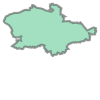

In [70]:
city